In [ ]:
import os, zipfile

ZIP_PATH = "/content/archive (2).zip"   
EXTRACT_TO = "/content/cars_dataset"

if not os.path.exists(EXTRACT_TO):
    print("Unzipping dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_TO)
    print("Done! Extracted to:", EXTRACT_TO)
else:
    print("Dataset already exists at:", EXTRACT_TO)

DIR = EXTRACT_TO + "/"

Unzipping dataset...
Done! Extracted to: /content/cars_dataset


In [2]:
IMAGE_LIST = [
    "/content/images3.jpg",
    "/content/images4.jpg",
    "/content/images8.jpg"
]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers, Model

IMG_SIZE = 299    
BATCH_SIZE = 32
VAL_SPLIT = 0.10
EPOCHS = 20
SEED = 42

print("Dataset folder:", DIR)


Dataset folder: /content/cars_dataset/


In [ ]:

for cls in os.listdir(DIR):
    path = os.path.join(DIR, cls)
    if not os.path.isdir(path):
        continue
    nested = os.path.join(path, cls)
    if os.path.isdir(nested):
        print("Fixing nested folder:", nested)
        for f in os.listdir(nested):
            shutil.move(os.path.join(nested, f), os.path.join(path, f))
        os.rmdir(nested)

for cls in os.listdir(DIR):
    cls_path = os.path.join(DIR, cls)
    if not os.path.isdir(cls_path):
        continue
    for f in os.listdir(cls_path):
        if not f.lower().endswith((".jpg", ".jpeg", ".png")):
            os.remove(os.path.join(cls_path, f))

print("Cleanup complete.")


Fixing nested folder: /content/cars_dataset/Audi/Audi
Cleanup complete.


In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as res_preprocess

RES_IMG = 224   

train_datagen_res = ImageDataGenerator(
    preprocessing_function=res_preprocess,
    validation_split=VAL_SPLIT,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_res = train_datagen_res.flow_from_directory(
    DIR,
    target_size=(RES_IMG, RES_IMG),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_res = train_datagen_res.flow_from_directory(
    DIR,
    target_size=(RES_IMG, RES_IMG),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

class_count_res = train_res.num_classes


Found 10399 images belonging to 19 classes.
Found 1145 images belonging to 19 classes.


In [6]:
from tensorflow.keras.applications import ResNet50

base_res = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(RES_IMG, RES_IMG, 3)
)

for layer in base_res.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_res.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(class_count_res, activation='softmax')(x)

resnet_model = Model(base_res.input, out)
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,648,595 (94.03 MB)

 Trainable params: 1,059,859 (4.04 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [7]:
checkpoint_res = "/content/resnet_cp.weights.h5"

cp_res = ModelCheckpoint(
    filepath=checkpoint_res,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_res = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1
)

early_res = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_res = resnet_model.fit(
    train_res,
    validation_data=val_res,
    epochs=EPOCHS,
    callbacks=[cp_res, reduce_lr_res, early_res],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.1336 - loss: 3.2933
Epoch 1: val_accuracy improved from -inf to 0.36769, saving model to /content/resnet_cp.weights.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 211s 603ms/step - accuracy: 0.1337 - loss: 3.2922 - val_accuracy: 0.3677 - val_loss: 2.1209 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.3166 - loss: 2.3086
Epoch 2: val_accuracy improved from 0.36769 to 0.44367, saving model to /content/resnet_cp.weights.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 178s 549ms/step - accuracy: 0.3167 - loss: 2.3084 - val_accuracy: 0.4437 - val_loss: 1.8566 - learning_rate: 1.0000e-04
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4026 - loss: 1.9768
Epoch 3: val_accuracy improved from 0.44367 to 0.48035, saving model to /content/resnet_cp.weights.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 177s 545ms/step - accuracy: 0.4026 - loss: 1.9768 - val_accuracy: 0.4803 - val_loss: 1.7204 - learning_rat

In [8]:
val_loss_res, val_acc_res = resnet_model.evaluate(val_res)
print("ResNet50 Validation Accuracy:", val_acc_res)


36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6619 - loss: 1.1341
ResNet50 Validation Accuracy: 0.687336266040802


In [9]:
def predict_with_resnet(img_path):
    img = load_img(img_path, target_size=(RES_IMG, RES_IMG))
    arr = img_to_array(img)
    arr = res_preprocess(arr)
    arr = np.expand_dims(arr, axis=0)

    pred = resnet_model.predict(arr)
    idx = np.argmax(pred)
    cls = list(train_res.class_indices.keys())[idx]
    print(f"ResNet Prediction for {img_path}: {cls}  ({pred[0][idx]:.4f})")



====== FINAL PREDICTIONS AFTER TRAINING ======


--- Predicting for: /content/images3.jpg ---


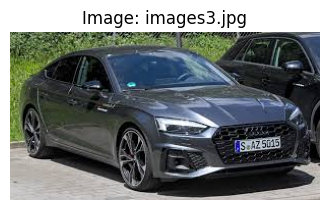

ResNet50 prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ResNet Prediction for /content/images3.jpg: Audi  (0.9863)
--------------------------------------------------

--- Predicting for: /content/images4.jpg ---


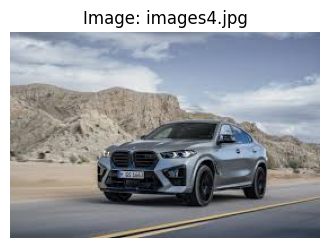

ResNet50 prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
ResNet Prediction for /content/images4.jpg: Bmw  (0.6999)
--------------------------------------------------

--- Predicting for: /content/images8.jpg ---


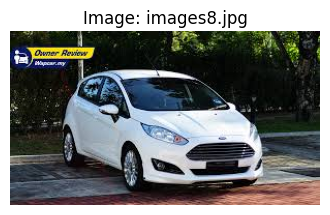

ResNet50 prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ResNet Prediction for /content/images8.jpg: Ford  (0.9649)
--------------------------------------------------


In [12]:
import matplotlib.pyplot as plt
from PIL import Image

print("\n====== FINAL PREDICTIONS AFTER TRAINING ======\n")

for img_path in IMAGE_LIST:
    print("\n--- Predicting for:", img_path, "---")

    # Display the image
    img = Image.open(img_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(img_path)}")
    plt.show()

    # ResNet prediction
    print("ResNet50 prediction:")
    predict_with_resnet(img_path)

    print("--------------------------------------------------")


36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step


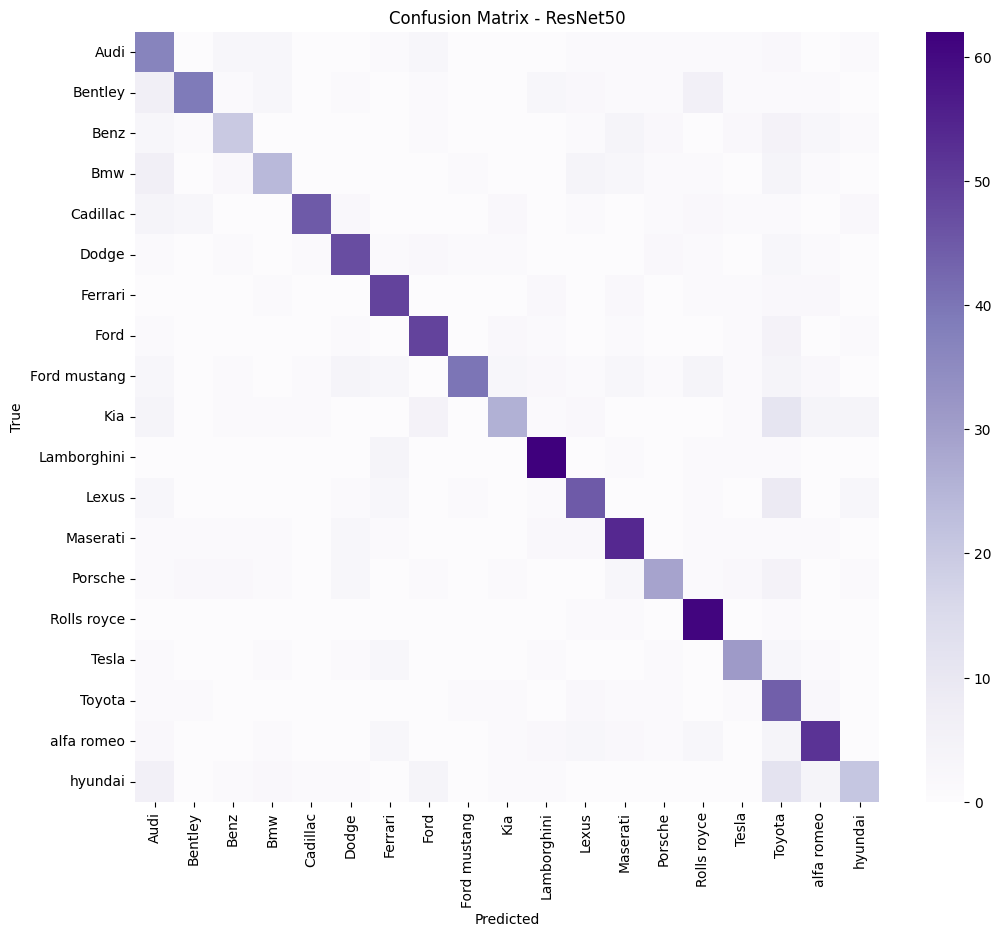


Classification Report - ResNet50:

              precision    recall  f1-score   support

        Audi       0.45      0.67      0.54        55
     Bentley       0.83      0.57      0.68        68
        Benz       0.61      0.47      0.53        43
         Bmw       0.63      0.50      0.56        48
    Cadillac       0.92      0.70      0.80        64
       Dodge       0.73      0.76      0.75        62
     Ferrari       0.72      0.82      0.77        60
        Ford       0.74      0.79      0.77        62
Ford mustang       0.91      0.55      0.68        73
         Kia       0.68      0.43      0.53        61
 Lamborghini       0.79      0.89      0.84        70
       Lexus       0.69      0.67      0.68        67
    Maserati       0.70      0.77      0.73        70
     Porsche       0.71      0.56      0.62        52
 Rolls royce       0.73      0.95      0.82        64
       Tesla       0.69      0.72      0.70        43
      Toyota       0.37      0.80      0.51  

In [ ]:

Y_pred_res = resnet_model.predict(val_res)
y_pred_res = np.argmax(Y_pred_res, axis=1)

y_true_res = val_res.classes


class_names_res = list(val_res.class_indices.keys())

# Confusion matrix
cm_res = confusion_matrix(y_true_res, y_pred_res)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_res, annot=False, cmap="Purples",
            xticklabels=class_names_res,
            yticklabels=class_names_res)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report - ResNet50:\n")
print(classification_report(y_true_res, y_pred_res, target_names=class_names_res))
